<a href="https://colab.research.google.com/github/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/segmentation-to-CT_scan-simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
#
#  Copyright 2025 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

![gVXR](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/Logo-transparent-small.png?raw=1)

# Digital twin of a CT synchrotron beamline: [Dual Imaging And Diffraction (DIAD)](https://www.diamond.ac.uk/Instruments/Imaging-and-Microscopy/DIAD.html)

This script shows how to load a segmented image and create a multi-part sample.
It relies on functions built in [gVXR](https://gvirtualxray.sourceforge.io/), i.e. no third-party software is required.
The functionality is multi-threaded to boost performances.
It is then used to simulate a CT scan acquisition with gVXR and its [DIAD beamline](https://www.diamond.ac.uk/Instruments/Imaging-and-Microscopy/DIAD.html) digital twin.
[CIL](https://ccpi.ac.uk/cil/) is eventually used to reconstruct the CT volume.

![Illustration here]()

<div class="alert alert-block alert-warning">
    <b>Note:</b> Make sure the Python packages are already installed. See <a href="../README.md">README.md</a> in the root directory of the repository. If you are running this notebook from Google Colab, please run the cell below to install the package with `!pip install gvxr`
</div>

Describe the segmentation here, including image file path, pixel size, and the material composition corresponding to each label in the segmented images. Note that the example provided makes use of 

- a chemical element (carbon) for Label 112 in the segmented image;
- a compound (silicon carbide) for Label 170; and
- a mixture (Ti-6Al-4V) for Label 202.

In [2]:
# To speed up the calculations, it acts as binning
downsampling_factor = 4 

# Repace with the path of your segmentation
segmentation_file_path = "../data/labels.tif"

# Replace with the corresponding values along the X, Y and Z axes respectively
voxel_size = [1.0, 1.0, 600] # We make it extra long along the Z-axis to extrude the object

# Replace with the corresponding unit as a string, e.g. "um", "mm", "cm", etc.
voxel_size_unit = "um"

material_composition = {
    112: {
        'material type': 'element',
        'material': 'C',
        'density': 2.26
    }
    ,

    170: {
        'material type': 'compound',
        'material': 'SiC',
        'density': 3.21
    },

    202: {
        'material type': 'mixture',
        'material': 'Ti90Al6V4',
        'density': 4.43
    }
}

Variables that you should not need to change

In [3]:
# Path where the data will be saved
import os
output_path = os.path.join("output_data", "DIAD")

# The position of the rotation centre during the CT acquisition
rotation_centre = [0, 0, 0]

# The number of projections during the CT acquisition
number_of_projections = 3000

Install packages if the code is running on Google Colab

In [4]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install libnvidia-gl-575
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    !conda install -y -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.3.0 ipp=2021.12 tigre

    !pip install gvxr

Import packages

In [42]:
# Who does not use Numpy?
import numpy as np

# Plotting
import matplotlib.pyplot as plt 

# User interface
import IPython
from IPython.display import display
from ipywidgets import widgets, Layout
from tqdm.notebook import tqdm

#  CT simulation
from PIL import Image
from gvxrPython3 import gvxr
from gvxrPython3.gVXRDataReader import *

# CT reconstruction
from cil.recon import FBP # For parallel beam geometry

from cil.io import TIFFWriter

from cil.processors import TransmissionAbsorptionConverter
from cil.utilities.display import show2D

Function declarations/definitions

In [6]:
def createSample():
    labels = np.array(Image.open(segmentation_file_path))

    if len(labels.shape) == 2:
        labels.shape = [1, *labels.shape]

    print("Unique labels in the segmentation:", np.unique(labels))
    for label in np.unique(labels):
        print("\tLabel: %i, Number of voxels:%i" % (label, np.sum(label == labels)))

    # Process the segmentation to create isosurfaces
    print("Process the segmentation to create isosurfaces")
    for label in tqdm(np.unique(labels)):

        if label in material_composition.keys():
            selected_material = material_composition[label]

            mesh_label = str(label) + "-" + material_composition[label]['material']

            # Select the structure
            binary_image = (labels == label).astype(np.uint8)

            # Apply the Marching cubes
            gvxr.makeIsoSurface(mesh_label,
                binary_image,
                1,
                *rotation_centre,
                *voxel_size,
                voxel_size_unit
            )

            # Save the mesh as an STL file
            gvxr.saveSTLfile(mesh_label, os.path.join(output_path, mesh_label+".stl"))

            # Set the material
            if selected_material['material type'].upper() == 'ELEMENT':
                gvxr.setElement(mesh_label, material_composition[label]['material'])

                if "density" in selected_material:
                    gvxr.setDensity(mesh_label, selected_material["density"], "g/cm3")

            elif selected_material['material type'].upper() == 'COMPOUND':
                gvxr.setCompound(mesh_label, material_composition[label]['material'])
                gvxr.setDensity(mesh_label, selected_material["density"], "g/cm3")

            elif selected_material['material type'].upper() == 'MIXTURE':
                gvxr.setMixture(mesh_label, material_composition[label]['material'])
                gvxr.setDensity(mesh_label, selected_material["density"], "g/cm3")

            else:
                raise IOError("Invalid material type")

            # Add the material
            gvxr.addPolygonMeshAsInnerSurface(mesh_label)
        else:
            print(label, "is not in", material_composition, "it'll be ignored.")

    return labels

In [7]:
def get_available_filters(twin, beam_type):
    return twin.specification.beams[beam_type].filters

In [8]:
def get_filter_material(twin, beam_type):

    filter_materials = ["None"]

    for item in get_available_filters(twin, beam_type):
        filter_materials.append(item[0])

    return filter_materials

In [9]:
def get_filter_thickness(twin, beam_type, material):

    thicknesses = [str(0.0)]

    filters = twin.specification.beams[beam_type].filters

    for item in filters:

        if item[0] == material:
            for thickness in item[1:]:
                thicknesses.append(str(thickness))

    return thicknesses

Class declarations/definitions

In [10]:
class UI:
    def __init__(self):
        pass

    def get_filter_material(self, twin, beam_type):

        filter_materials = ["None"]

        for item in get_available_filters(twin, beam_type):
            filter_materials.append(item[0])

        return filter_materials

    def get_filter_thickness(self, twin, beam_type, material):

        thicknesses = [str(0.0)]

        filters = twin.specification.beams[beam_type].filters

        for item in filters:

            if item[0] == material:
                for thickness in item[1:]:
                    thicknesses.append(str(thickness))

        return thicknesses


    def create(self):

        global twin

        def on_filter_material_value_change(change):

            # Update the values in the UI
            filter_material = self.filter_material_type_widget.value
            thicknesses = self.get_filter_thickness(twin, self.spectrum_type_widget.value, filter_material)
            filter_thickness = float(self.filter_thickness_widget.value)

            if filter_material != "None" and filter_thickness > 1e-6:
                twin.beam.filter = (filter_material, filter_thickness)
            else:
                twin.beam.filter = []

            self.filter_thickness_widget.value = thicknesses[0]
            self.filter_thickness_widget.options = thicknesses

            # Plot the spectrum
            self.update_spectrum_plot()


        def on_filter_thickness_value_change(change):

            filter_material = self.filter_material_type_widget.value
            filter_thickness = float(self.filter_thickness_widget.value)

            if filter_thickness > 1e-6 and filter_material != "None":
                twin.beam.filter = [filter_material, filter_thickness]
            else:
                twin.beam.filter = []

            # Plot the spectrum
            self.update_spectrum_plot()

        def on_energy_value_change(change):

            global twin

            # Change the energy
            twin.beam.kev = change["new"]

            self.update_spectrum_plot()

        def on_exposure_value_change(change):

            global twin

            # Change the energy
            twin.detector.exposure = change["new"]

            self.update_spectrum_plot()

        def on_spectrum_type_value_change(change):

            twin.set_beam(change['new'])

            # Update the UI
            if change['new'] == 'monochromatic':
                self.filter_selection_box.disabled = True

                for child in self.filter_selection_box.children:
                    child.disabled = True

                for child in self.mono_energy_box.children:
                    child.disabled = False

            else:
                self.filter_selection_box.disabled = False

                for child in self.filter_selection_box.children:
                    child.disabled = False

                for child in self.mono_energy_box.children:
                    child.disabled = True

            # Update the values in the UI
            self.filter_material_type_widget.value = "None"
            self.filter_material_type_widget.options = self.get_filter_material(twin, self.spectrum_type_widget.value)

            filter_material = self.filter_material_type_widget.value
            thicknesses = self.get_filter_thickness(twin, self.spectrum_type_widget.value, filter_material)
            self.filter_thickness_widget.value = thicknesses[0]
            self.filter_thickness_widget.options = thicknesses

            # Plot the spectrum
            self.update_spectrum_plot()

        # Select the spectrum to use
        # spectrum_type_widget = widgets.RadioButtons(
        #     options=['Monochromatic', 'Pink-beam (low angle)', 'Pink-beam (high angle)'],
        #     # description='Beam spectrum:',
        #     disabled=False,
        #     value='Monochromatic',
        #     layout={'width': 'max-content'}
        # )

        self.spectrum_type_widget = widgets.Select(
            options=twin.get_beams(),
            # description='Beam spectrum:',
            disabled=False,
            value=twin.get_beams()[0],
            layout={'width': 'max-content'}
        )

        # Make it look nice
        self.beam_selection_box = widgets.Box(
            [
                widgets.Label(value='Select the type of spectrum:'),
                self.spectrum_type_widget
            ]
        )

        # If you selected a pink beam, i.e. a poychromatic beam as the monochromator was not used, you may select a filter.
        self.filter_material_type_widget = widgets.Select(
            options=self.get_filter_material(twin, self.spectrum_type_widget.value),
            # description='Filter material:',
            disabled=False,
            value='None',
            layout={'width': 'max-content'}
        )

        # If you selected a pink beam, i.e. a poychromatic beam as the monochromator was not used, you may select a filter.
        filter_material = self.filter_material_type_widget.value
        thicknesses = self.get_filter_thickness(twin, self.spectrum_type_widget.value, filter_material)
        self.filter_thickness_widget = widgets.Select(
            options=thicknesses,
            # description='Filter thickness [mm]:',
            disabled=False,
            value=thicknesses[0],
            layout={'width': 'max-content'}
        )

        self.filter_selection_box = widgets.Box(
            [
                widgets.Label(value='Filter material:'),
                self.filter_material_type_widget,
                widgets.Label(value='Filter thickness [mm]:'),
                self.filter_thickness_widget
            ]
        )

        # Else select the energy
        twin_max_energy = max(twin.specification.beams["monochromatic"].keV)
        twin_min_energy = min(twin.specification.beams["monochromatic"].keV)
        self.energy_selector_widget = widgets.FloatSlider(
            value=twin_min_energy + (twin_max_energy - twin_min_energy) / 2.0,
            min=twin_min_energy,
            max=twin_max_energy,
            step=0.1,
            # description='Mono-energy [keV]:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )

        # Make it look nice
        self.mono_energy_box = widgets.Box(
            [
                widgets.Label(value='Mono-energy [keV]:'),
                self.energy_selector_widget
            ]
        )


        if self.spectrum_type_widget.value == 'monochromatic':
            self.filter_selection_box.disabled = True

            for child in self.filter_selection_box.children:
                child.disabled = True

            for child in self.mono_energy_box.children:
                child.disabled = False

        else:
            self.filter_selection_box.disabled = False

            for child in self.filter_selection_box.children:
                child.disabled = False

            for child in self.mono_energy_box.children:
                child.disabled = True

        # Select the exposure
        self.exposure_widget = widgets.FloatSlider(
            value=0.1,
            min=0.5,
            max=1.0,
            step=0.1,
            # description='Exposure [sec]:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )

        # Make it look nice
        self.exposure_box = widgets.Box(
            [
                widgets.Label(value='Exposure [sec]:'),
                self.exposure_widget
            ]
        )

        self.spectrum_plot_widget = widgets.Output(layout=Layout(width='50%'))


        # Update the visibility of widgets
        self.spectrum_type_widget.observe(on_spectrum_type_value_change, names='value')

        # Update the filter thicknesses based on the material
        self.filter_material_type_widget.observe(on_filter_material_value_change, names='value')
        self.filter_thickness_widget.observe(on_filter_thickness_value_change, names='value')

        # Update the spectrum
        self.energy_selector_widget.observe(on_energy_value_change, names='value')
        self.exposure_widget.observe(on_exposure_value_change, names='value')



        # self.spectrum_type_widget.observe(on_energy_value_change, names='value')
        # self.filter_material_type_widget.observe(on_energy_value_change, names='value')
        # self.filter_thickness_widget.observe(on_energy_value_change, names='value')


        self.layout_left_column = widgets.VBox([self.beam_selection_box, self.mono_energy_box, self.filter_selection_box, self.exposure_box])
        self.layout_two_columns = widgets.HBox([self.layout_left_column, self.spectrum_plot_widget])

        # Plot the correspoding spectrum
        self.update_spectrum_plot()

        display(self.layout_two_columns)



    def update_spectrum_plot(self):

        twin.apply()

        energy_bins = gvxr.getEnergyBins("keV")
        photon_counts = gvxr.getPhotonCountsPerPixelAtSDD()

        with self.spectrum_plot_widget:
            # print(change["new"])

            IPython.display.clear_output(True)
            fig = plt.figure(figsize=(10,5), dpi=90)
            fig.canvas.toolbar_visible = False
            ax = fig.add_subplot(111)

            if len(energy_bins) == 1:
                twin_max_energy = max(twin.specification.beams["monochromatic"].keV)
                twin_min_energy = min(twin.specification.beams["monochromatic"].keV)
                ax.set_xlim((twin_min_energy, twin_max_energy))

            ax.bar(energy_bins, photon_counts)

            ax.set_xlabel("Incident energy [keV]")
            ax.set_ylabel("Number of photons per pixels")
            plt.show()

Create the directory were the STL files will be saved

In [11]:
output_dir_projs = os.path.join(output_path, "projs")
if not os.path.exists(output_dir_projs):
    print("Creating output directory at {}".format(output_dir_projs))
    os.makedirs(output_dir_projs)

output_dir_recons = os.path.join(output_path, "recons")
if not os.path.exists(output_dir_recons):
    print("Creating output directory at {}".format(output_dir_recons))
    os.makedirs(output_dir_recons)

Create a simulation engine with mixed-precision

In [12]:
# Create an OpenGL context
opengl_major = 4
opengl_minor = 6
floating_point_precision = 0 # Use 16 for half-precision, 32 for full-precision, 0 for mixed-precision
gvxr.createOpenGLContext(-1, opengl_major, opengl_minor, floating_point_precision)

Mon Oct  6 17:41:38 2025 ---- Create window (ID: -1)
Mon Oct  6 17:41:38 2025 ---- Request an interactive OpenGL context
Mon Oct  6 17:41:38 2025 ---- Initialise GLFW
Mon Oct  6 17:41:38 2025 ---- Create an OpenGL window with a 4.6 context.
Mon Oct  6 17:41:39 2025 ---- Make the window's context current
Mon Oct  6 17:41:39 2025 ---- Initialise GLEW
Mon Oct  6 17:41:39 2025 ---- OpenGL vendor: NVIDIA Corporation
Mon Oct  6 17:41:39 2025 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Mon Oct  6 17:41:39 2025 ---- OpenGL version: 4.6.0 NVIDIA 570.153.02
Mon Oct  6 17:41:39 2025 ---- Use OpenGL 4.5.
Mon Oct  6 17:41:39 2025 ---- Use OpenGL Compute Shader.
Mon Oct  6 17:41:39 2025 ---- Initialise the X-ray renderer if needed and if possible


Create the sample from a segmented image

In [13]:
labels = createSample()

for i in range(gvxr.getNumberOfChildren("root")):
    gvxr.rotateNode(gvxr.getChildLabel("root", i), 90, 1, 0, 0)

Unique labels in the segmentation: [112 170 202]
	Label: 112, Number of voxels:31313
	Label: 170, Number of voxels:203424
	Label: 202, Number of voxels:140263
Process the segmentation to create isosurfaces


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Display the image

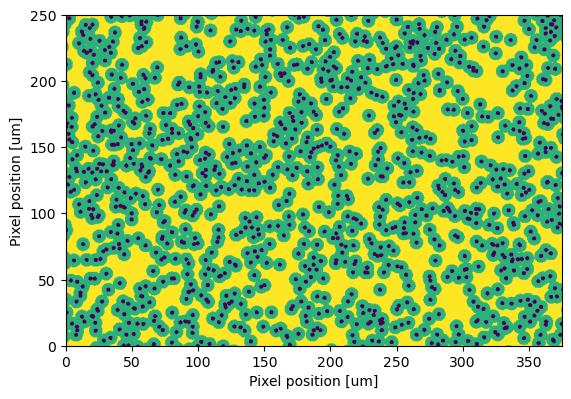

In [14]:
plt.figure()
plt.imshow(labels[0],
    origin='upper',
    extent=[0.0, voxel_size[0] * labels.shape[2],
        0.0, voxel_size[1] * labels.shape[1]]
)
plt.xlabel("Pixel position [" + voxel_size_unit + "]")
plt.ylabel("Pixel position [" + voxel_size_unit + "]")
plt.show()

Import the twin package

In [15]:
from gvxrPython3.twins.utils import createDigitalTwin

Create a DIAD twin

In [16]:
twin = createDigitalTwin(name="DIAD")
twin.apply() # We apply now so that there is no extra output in the iPython widget

Mon Oct  6 17:41:41 2025 ---- Initialise the renderer with mixed-precision floating-point numbers in GPU memory


Downsample if needed

In [19]:
if downsampling_factor > 1:

    for resolution in twin.specification.detector.resolutions:
        resolution[0] = round(resolution[0] / downsampling_factor)
        resolution[1] = round(resolution[1] / downsampling_factor)

    twin.specification.detector.pixel_pitch *= downsampling_factor

The DIAD's detector is too big for my laptop's GPU, if it is the case, we crop it

In [21]:
try:
    twin.apply()
except Exception as e:

    # In case the detector is too big for the GPU, e.g. on my laptop
    # Resize it
    if "The biggest 3D texture with this graphics card is" in str(e):

        # Get the second line of the error message as it'll display the largest 3D texture supported by the GPU
        tmp_line = str(e).splitlines()[1]
        max_texture_size = list(map(int, re.findall(r'\d+', tmp_line)))
        detector_size = (max_texture_size[1], max_texture_size[2])
        twin.specification.detector.resolutions = [detector_size]

        print("Detector too big for GPU, we'll reduce it to %ix%i" % (detector_size[0], detector_size[1]))
        gvxr.setDetectorNumberOfPixels(*detector_size)

        twin.apply()
        pass
    else:
        raise e

Mon Oct  6 17:43:28 2025 ---- Initialise the renderer with mixed-precision floating-point numbers in GPU memory


Create a small UI to select the beam (spectrum and exposure)

In [22]:
diad_ui = UI()
diad_ui.create()

Mon Oct  6 17:43:32 2025 ---- Initialise the renderer with mixed-precision floating-point numbers in GPU memory


Mon Oct  6 17:43:34 2025 ---- Initialise the renderer with mixed-precision floating-point numbers in GPU memory


Mon Oct  6 17:43:35 2025 ---- Initialise the renderer with mixed-precision floating-point numbers in GPU memory


ADD FILTERS Al 1.0


ADD FILTERS Al 4.0


Mon Oct  6 17:43:39 2025 ---- Initialise the renderer with mixed-precision floating-point numbers in GPU memory


When you are happy with the spectrum, keep going

We create a radiograph to double check everything is fine

In [23]:
gvxr.disablePoissonNoise()

total_energy = gvxr.getTotalEnergyWithDetectorResponse(True)
total_energy_with_gain = total_energy * 2845.377851132412

xray_image_without_noise = np.asarray(gvxr.computeXRayImage(), dtype=np.single) / total_energy

gvxr.enablePoissonNoise()
# xray_image_with_noise = np.asarray(gvxr.computeXRayImage(), dtype=np.single) / total_energy

## THIS IS A HACK TO ACCOUNT FOR THE GAIN
xray_image_with_noise = 2845.377851132412 * np.asarray(gvxr.computeXRayImage(), dtype=np.single)

if total_energy_with_gain > 65535:
    total_energy_with_gain = 65535
    print("Overexposure is very likely")
elif total_energy_with_gain > 60000:
    print("Overexposure is very possible")

total_energy_with_gain = round(total_energy_with_gain)

xray_image_with_noise[xray_image_with_noise > 65535] = 65535
xray_image_with_noise = xray_image_with_noise.astype(np.uint16)
xray_image_with_noise = xray_image_with_noise.astype(np.single) / total_energy_with_gain



Text(0, 0.5, 'Pixel position [um]')

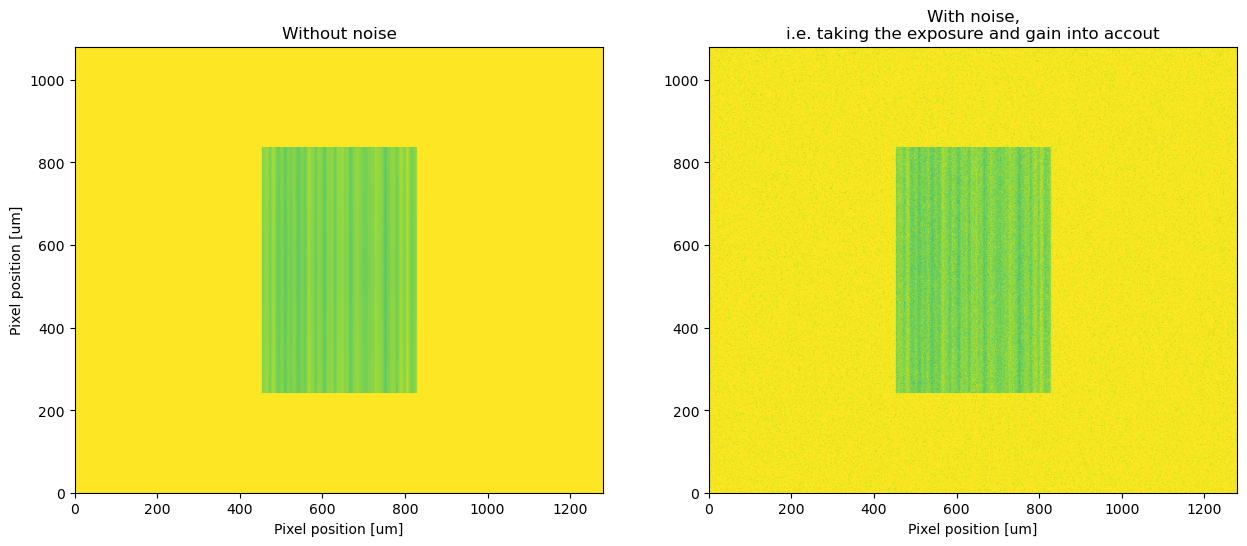

In [31]:
f, axarr = plt.subplots(1,2, figsize=(15, 7))
axarr[0].set_title("Without noise")
axarr[0].imshow(xray_image_without_noise, vmin=0.0, vmax=1.0,
    origin='upper',
    extent=[0.0, gvxr.getDetectorPixelSpacing("um")[0] * xray_image_without_noise.shape[1],
        0.0, gvxr.getDetectorPixelSpacing("um")[1] * xray_image_without_noise.shape[0]]
)

axarr[1].set_title("With noise,\ni.e. taking the exposure and gain into accout")
axarr[1].imshow(xray_image_with_noise, vmin=0.0, vmax=1.0,
    origin='upper',
    extent=[0.0, gvxr.getDetectorPixelSpacing("um")[0] * xray_image_with_noise.shape[1],
        0.0, gvxr.getDetectorPixelSpacing("um")[1] * xray_image_with_noise.shape[0]])

axarr[0].set_xlabel("Pixel position [um]")
axarr[1].set_xlabel("Pixel position [um]")
axarr[0].set_ylabel("Pixel position [um]")


If you are not happy, iterate by altering the spectrum in the UI above (e.g. maybe increase the exposure)

Simulate the CT scan

In [47]:
gvxr.enablePoissonNoise()

gvxr.computeCTAcquisition(
    output_dir_projs, # The path where the X-ray projections will be saved
    "", # The path where the screenshots will be saved
    number_of_projections, # The total number of projections to simulate
    0, # The rotation angle corresponding to the first projection
    False, # A boolean flag to include or exclude the last angle
    180, # The rotation angle corresponding to the first projection
    50, # The number of white images used to perform the flat-field correction
    *rotation_centre, # The location of the rotation centre
    "mm", # The corresponding unit of length
    *gvxr.getDetectorUpVector(), # The rotation axis
    True,
    1
)  

Mon Oct  6 17:52:54 2025 ---- The directory "output_data/DIAD/projs" already exists.
Mon Oct  6 17:52:54 2025 ---- Empty and delete the directory "output_data/DIAD/projs".
Mon Oct  6 17:52:54 2025 ---- Create the directory "output_data/DIAD/projs".
Mon Oct  6 17:52:54 2025 ---- Performing CT Scan.
Mon Oct  6 17:52:54 2025 ---- 	Energy fluence (integrated energy):	YES
Mon Oct  6 17:52:54 2025 ---- 	X-ray projections will be stored in the RAM:	NO
Mon Oct  6 17:52:54 2025 ---- 	X-ray projections will be saved in:	output_data/DIAD/projs
Mon Oct  6 17:52:54 2025 ---- 	Total number of X-ray projections:	3000
Mon Oct  6 17:52:54 2025 ---- 	First angle (in degrees):	0
Mon Oct  6 17:52:54 2025 ---- 	Last angle (in degrees):	180
Mon Oct  6 17:52:54 2025 ---- 	Include the last angle:	NO
Mon Oct  6 17:52:54 2025 ---- 	Rotation angles:	[0, 0.06, ..., 179.88, 179.94]
Mon Oct  6 17:52:54 2025 ---- 	Perform the flat-field correction:	YES
Mon Oct  6 17:52:54 2025 ---- 	Number of white images in the fla

Read the simulated data with CIL

In [48]:
reader = gVXRDataReader(gvxr.getProjectionOutputPathCT(),
    gvxr.getAngleSetCT(),
    rotation_centre)

data = reader.read()

[ 0.  0. -1.]
[  -0.   -0. -200.]
[0, 0, 0]
(0.0, 1.0, 0.0)
[640 540]
[0.002000000141561031, 0.002000000141561031]


In [49]:
print("data.geometry", data.geometry)

data.geometry 3D Parallel-beam tomography
System configuration:
	Ray direction: [ 0.,  0., -1.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 1., 0.]
	Detector position: [  -0.,   -0., -200.]
	Detector direction x: [-1., -0.,  0.]
	Detector direction y: [-0., -1., -0.]
Panel configuration:
	Number of pixels: [640 540]
	Pixel size: [0.002 0.002]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3000
	Angles 0-9 in degrees: [0.        , 0.06      , 0.12      , 0.17999999, 0.24      , 0.29999998,
 0.35999998, 0.42      , 0.48      , 0.53999996]
	Angles 2990-2999 in degrees: [179.4    , 179.45999, 179.51999, 179.58   , 179.64   , 179.7    ,
 179.76   , 179.81999, 179.87999, 179.94   ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


Apply the minus log transformation (use use white_level=1.0 as the flat-field correction is already applied)

In [50]:
data_corr = TransmissionAbsorptionConverter(white_level=1.0)(data)

In [51]:
data_corr.reorder(order='tigre')

We only want to reconstruct the slice in the middle of the volume

In [52]:
ig = data_corr.geometry.get_ImageGeometry();

ig.voxel_num_z = 1
print("Image geometry", ig)

Image geometry Number of channels: 1
channel_spacing: 1.0
voxel_num : x640,y640,z1
voxel_size : x0.002000000141561031,y0.002000000141561031,z0.002000000141561031
center : x0,y0,z0



In [53]:
# Perform the reconstruction with CIL
FBP_reconstruction = FBP(data_corr, ig).run()

FBP recon

Input Data:
	angle: 3000
	vertical: 540
	horizontal: 640

Reconstruction Volume:
	horizontal_y: 640
	horizontal_x: 640

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



Apply a circular mask as we simulated a region of interest scan

In [54]:
FBP_reconstruction.apply_circular_mask()

Save the reconstructed CT images

In [55]:
writer = TIFFWriter(data=FBP_reconstruction, file_name=output_dir_recons, compression="uint16");
writer.write();

Show the CT slice

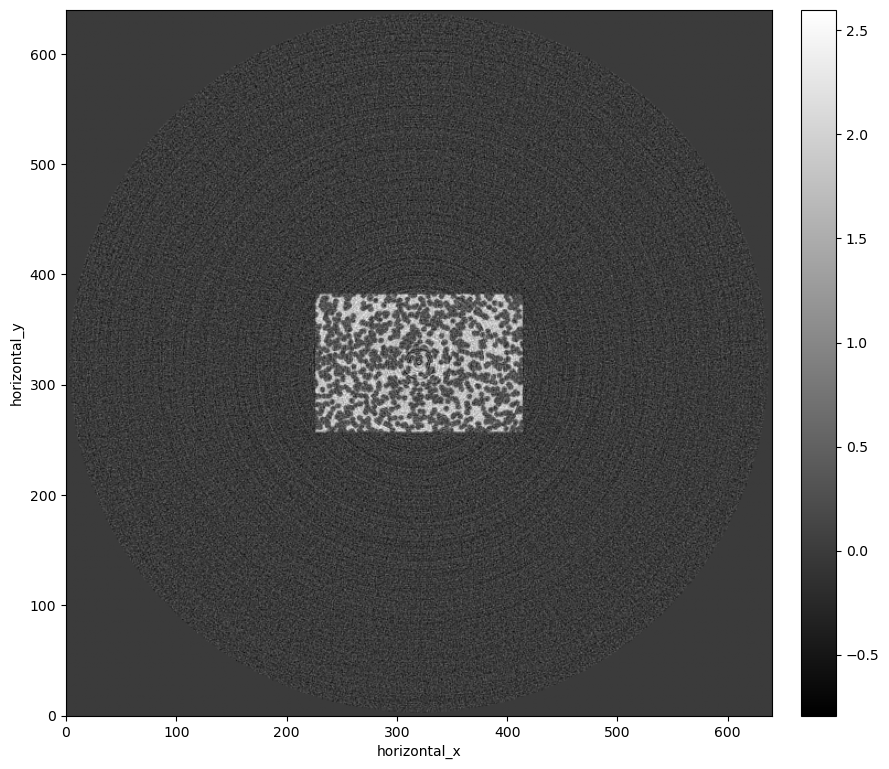

In [56]:
show2D(FBP_reconstruction)

# Cleaning up

Once we have finished, it is good practice to clean up the OpenGL contexts and windows with the following command. Note that due to the object-oriented programming nature of the core API of gVXR, this step is automatic anyway.

In [57]:
gvxr.destroy()

Mon Oct  6 17:55:01 2025 ---- Release all the memory
Mon Oct  6 17:55:01 2025 ---- Destroy all the windows
Mon Oct  6 17:55:01 2025 ---- Destroy window 0(0x557f1d4f0c70)
